In [1]:
from dstreader import DstFile

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from typing import Dict, Tuple

In [2]:
# suffix - meaning
#      0 - all particles, regular dst files
#      1 - gamma (part id 1)
#      2 - e +/- (part id 2 and 3)
#      3 - mu +/- (part id 5 and 6)
#      4 - hadrons (part ids > 6)
#      5 - noise???


In [3]:
all_dst = DstFile("example/DAT009512_0_gea.dst.gz")
mu_dst = DstFile("example/DAT009512_3_gea.dst.gz")
el_dst = DstFile("example/DAT009512_2_gea.dst.gz")
gamma_dst = DstFile("example/DAT009512_1_gea.dst.gz")
hadrons_dst = DstFile("example/DAT009512_4_gea.dst.gz")
noise_dst = DstFile("example/DAT009512_5_gea.dst.gz")


dst_files = [all_dst, mu_dst, el_dst, gamma_dst, hadrons_dst, noise_dst]
for dst in dst_files:
    dst.open()
dst_file_labels = ["total", r"$\mu^{+/-}$", r"$e^{+/-}$", r"$\gamma$", "hadrons", "noise"]

event_iters = [dst.events() for dst in dst_files]

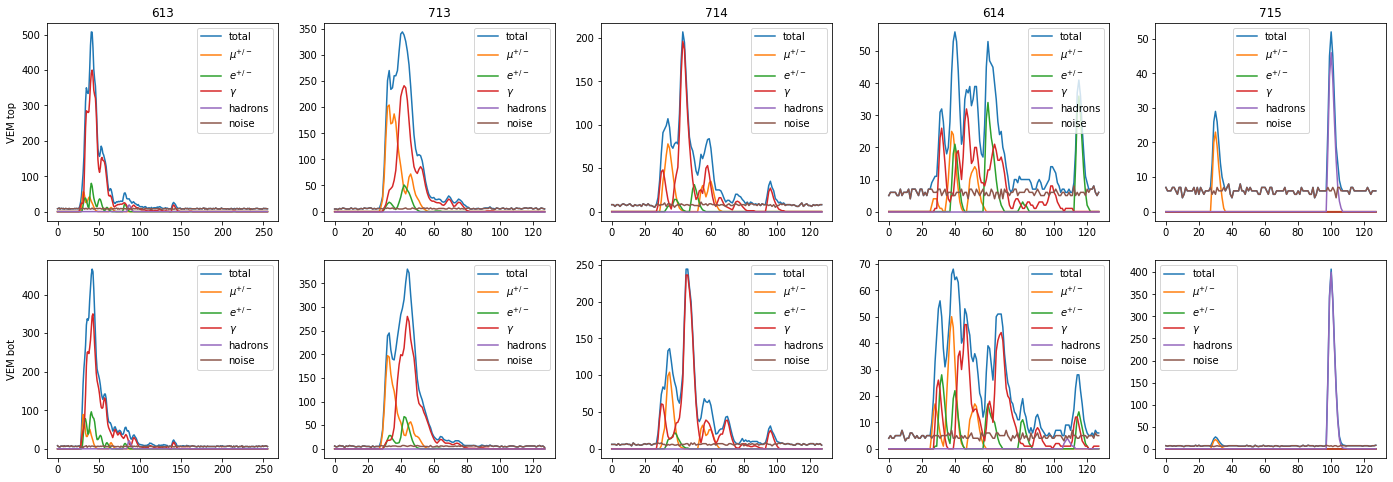

In [20]:
n_top_waveforms = 5

fig, axes = plt.subplots(nrows=2, ncols=n_top_waveforms, figsize=(24, 8))

detectors_to_plot = None

for dst_label, event_iter, dst in zip(dst_file_labels, event_iters, dst_files):
    next(event_iter)
    rusdraw = dst.get_bank('rusdraw')
    fadc = rusdraw['fadc']
    wf_id = rusdraw['wf_id']
    xxyy = rusdraw['xxyy']
    waveform_parts_by_detector = defaultdict(dict)
    for i, (xxyy_, wf_id_) in enumerate(zip(xxyy, wf_id)):
        waveform_parts_by_detector[xxyy_][wf_id_] = fadc[i]
    
    # assembling waveforms from their 128-bin parts
    def assemble_waveforms(wf_part_by_id: Dict[int, Dict[int, np.ndarray]]) -> Tuple[np.ndarray, np.ndarray]:
        wf_top = []
        wf_bot = []
        for wf_id in sorted(wf_part_by_id.keys()):
            wf_top.extend(wf_part_by_id[wf_id][0])
            wf_bot.extend(wf_part_by_id[wf_id][1])
        return np.array(wf_top), np.array(wf_bot)

    waveforms_by_detector = {xxyy_: assemble_waveforms(wfp) for xxyy_, wfp in waveform_parts_by_detector.items()}

    if detectors_to_plot is None:
        # looking for max integral waveforms
        detector_with_integral = [
            (xxyy_, np.sum(wf_top) + np.sum(wf_bot))
            for xxyy_, (wf_top, wf_bot) in waveforms_by_detector.items()
        ]
        detector_with_integral.sort(key=lambda d_i: d_i[1], reverse=True)
        detectors_to_plot = [xxyy_ for (xxyy_, _) in detector_with_integral[:n_top_waveforms]]

    for icol, xxyy_ in enumerate(detectors_to_plot):
        for irow, wf in enumerate(waveforms_by_detector[xxyy_]):
            ax: plt.Axes = axes[irow][icol]
            if irow == 0:
                ax.set_title(str(xxyy_))
            if icol == 0:
                ax.set_ylabel("VEM " + ("top" if irow == 0 else "bot"))
            ax.plot(wf, label=dst_label)
            ax.legend()

plt.savefig("waveforms-example.png", bbox_inches="tight")
plt.show()


In [ ]:
# reconstruction -> cuts

# каты:
# * spectral
# * anizotropy (ослаблены отн. spectral)
# * ML (усилены отн. special)

# tasdmc
# конфигурация катов в момент дампа

In [6]:
print(rusdraw.doc)


integer4 event_num;		                        /* event number */
integer4 event_code;                                  /* 1=data, 0=Monte Carlo */
integer4 site;                                        /* BR=0,LR=1,SK=2,BRLR=3,BRSK=4,LRSK=5,BRLRSK=6 */
integer4 run_id[3];                                   /* run number for [0]-BR,[1]-LR,[2]-SK, -1 if irrelevant */
integer4 trig_id[3];		                        /* event trigger id for each tower, -1 if irrelevant */
integer4 errcode;                                     /* should be zero if there were no readout problems */
integer4 yymmdd;		                        /* event year, month, day */
integer4 hhmmss;		                        /* event hour minut second */
integer4 usec;		                        /* event micro second */
integer4 monyymmdd;                                   /* yymmdd at the beginning of the mon. cycle used in this event */
integer4 monhhmmss;                                   /* hhmmss at the beginning of the mon. c

In [16]:
for dst in dst_files:
    dst.close()